# Fisherfaces

## Librerias

In [ ]:
%matplotlib inline

import os
import cv2
import glob
import numpy as np
import random
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from scipy.stats import mode


## Carga de datos

In [32]:
# --- CONFIGURACIÓN ---
IMG_SIZE = (100, 100)
CLASES_MAP = {
    "joy": 0, "joyful": 0,
    "neutral": 1,
    "distraction": 2, "distracted": 2,
    "fatigue": 3, "fatigued": 3,
    "confusion": 4, "confused": 4
}

# 1. Cargar el detector desde el archivo local
cascade_path = 'haarcascade_frontalface_default.xml'
face_cascade = cv2.CascadeClassifier(cascade_path)

# Verificación inmediata
if face_cascade.empty():
    print(f"ERROR: Archivo no encontrado en '{cascade_path}'.")
else:
    print("Detector cargado correctamente desde archivo local.")

def detectar_y_recortar(img):
    """ Detecta rostro, recorta y devuelve. Si falla, devuelve original. """
    if face_cascade.empty(): return img
    
    # Haar funciona mejor en escala de grises
    rostros = face_cascade.detectMultiScale(img, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))
    
    if len(rostros) > 0:
        # Tomar el rostro más grande (area = w * h)
        x, y, w, h = max(rostros, key=lambda b: b[2] * b[3])
        return img[y:y+h, x:x+w]
    return img

def cargar_datos_fisher_mejorado(ruta_split):
    X = []
    y = []
    print(f"Procesando: {ruta_split}")
    
    if not os.path.exists(ruta_split):
        print(f"La ruta no existe: {ruta_split}")
        return np.array([]), np.array([])

    carpetas_emocion = os.listdir(ruta_split)
    
    for nombre_carpeta in carpetas_emocion:
        nombre_lower = nombre_carpeta.lower()
        if nombre_lower in CLASES_MAP:
            label = CLASES_MAP[nombre_lower]
            ruta_emocion = os.path.join(ruta_split, nombre_carpeta)
            
            # Recorrer archivos
            for archivo in os.listdir(ruta_emocion):
                ruta_img = os.path.join(ruta_emocion, archivo)
                try:
                    # Leer en gris
                    img = cv2.imread(ruta_img, 0)
                    if img is not None:
                        # Detectar -> Recortar -> Resize
                        img_face = detectar_y_recortar(img)
                        img_resized = cv2.resize(img_face, IMG_SIZE)
                        
                        X.append(img_resized.flatten())
                        y.append(label)
                except Exception as e:
                    pass # Ignorar imágenes corruptas

    return np.array(X), np.array(y)

# --- EJECUCIÓN ---
if not face_cascade.empty():
    base_path = "Synthetic_DB_CAS" # Verifica que esta ruta sea correcta
    
    print("--- Recargando TRAIN ---")
    X_train, y_train = cargar_datos_fisher_mejorado(os.path.join(base_path, "train"))
    
    print("--- Recargando VAL ---")
    X_val, y_val = cargar_datos_fisher_mejorado(os.path.join(base_path, "val"))
    
    print("--- Recargando TEST ---")
    X_test, y_test = cargar_datos_fisher_mejorado(os.path.join(base_path, "test"))
    
    print(f"\nDimensiones finales Train: {X_train.shape}")

Detector cargado correctamente desde archivo local.
--- Recargando TRAIN ---
Procesando: Synthetic_DB_CAS\train
--- Recargando VAL ---
Procesando: Synthetic_DB_CAS\val
--- Recargando TEST ---
Procesando: Synthetic_DB_CAS\test

Dimensiones finales Train: (424, 10000)


## Preparación de datos

In [4]:
print("--- Preparando Datos ---")
# Concatenamos las filas (axis=0) de Train y Val
X_full_train = np.concatenate((X_train, X_val), axis=0)
y_full_train = np.concatenate((y_train, y_val), axis=0)

print(f"Set de Entrenamiento Completo (Train+Val): {X_full_train.shape}")
print(f"Set de Prueba (Test): {X_test.shape}")


--- Preparando Datos ---
Set de Entrenamiento Completo (Train+Val): (514, 10000)
Set de Prueba (Test): (92, 10000)


## Estandarizar

In [5]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_full_train)
X_test_scaled = scaler.transform(X_test)

## PCA

In [6]:
# Usamos .95 para conservar el 95% de la varianza original y reducir ruido
pca = PCA(n_components=0.95, whiten=True, random_state=42)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

print(f"Dimensiones tras PCA: {X_train_pca.shape[1]} componentes principales (de 10,000 originales)")


Dimensiones tras PCA: 148 componentes principales (de 10,000 originales)


## LDA

In [7]:
lda = LDA()
lda.fit(X_train_pca, y_full_train)
print("Modelo LDA entrenado exitosamente.")

Modelo LDA entrenado exitosamente.


In [8]:
sns.set_style("whitegrid")
nombres_clases = ["Joy", "Neutral", "Distraction", "Fatigue", "Confusion"]

# --- VISUALIZACIÓN 1: Muestras de Entrada ---
def plot_samples(X, y, n_samples=5):
    fig, axes = plt.subplots(1, n_samples, figsize=(15, 3))
    for i in range(n_samples):
        # Tomamos un índice aleatorio
        idx = np.random.randint(0, len(X))
        
        img = X[idx].reshape(100, 100)
        label = nombres_clases[y[idx]]
        
        axes[i].imshow(img, cmap='gray')
        axes[i].set_title(f"Clase: {label}")
        axes[i].axis('off')
    plt.suptitle("Ejemplos de entrada (Preprocesados)", fontsize=16)
    plt.show()

# --- VISUALIZACIÓN 2: El "Rostro Promedio" y los "Eigenfaces" ---
def plot_eigenfaces(pca_model):
    fig, axes = plt.subplots(1, 6, figsize=(18, 4))
    
    # 1. El rostro promedio (Mean Face)
    mean_face = pca_model.mean_.reshape(100, 100)
    axes[0].imshow(mean_face, cmap='gray')
    axes[0].set_title("Rostro Promedio\n(Mean Face)")
    axes[0].axis('off')
    
    # 2. Los primeros 5 componentes principales (Eigenfaces)
    for i in range(5):
        eigenface = pca_model.components_[i].reshape(100, 100)
        axes[i+1].imshow(eigenface, cmap='viridis') # Viridis ayuda a ver contrastes
        axes[i+1].set_title(f"Eigenface #{i+1}")
        axes[i+1].axis('off')
        
    plt.suptitle("Interior del PCA: Rostro Promedio y Componentes Principales", fontsize=16)
    plt.show()

# --- VISUALIZACIÓN 3: Proyección en Espacio LDA (2D) ---
def plot_lda_space(lda_model, X_pca, y_true):
    X_lda = lda_model.transform(X_pca)
    
    plt.figure(figsize=(10, 8))
    
    # Usamos scatterplot para ver la agrupación
    # Solo podemos graficar 2 dimensiones en pantalla plana (LD1 vs LD2)
    sns.scatterplot(x=X_lda[:, 0], y=X_lda[:, 1], hue=[nombres_clases[i] for i in y_true], 
                    palette="deep", s=60, alpha=0.7)
    
    plt.title("Proyección de Fisher (LDA): Separación de Clases", fontsize=16)
    plt.xlabel("Primer Discriminante Lineal (LD1)")
    plt.ylabel("Segundo Discriminante Lineal (LD2)")
    plt.legend(title="Emoción")
    plt.show()

Generando gráficas del proceso...


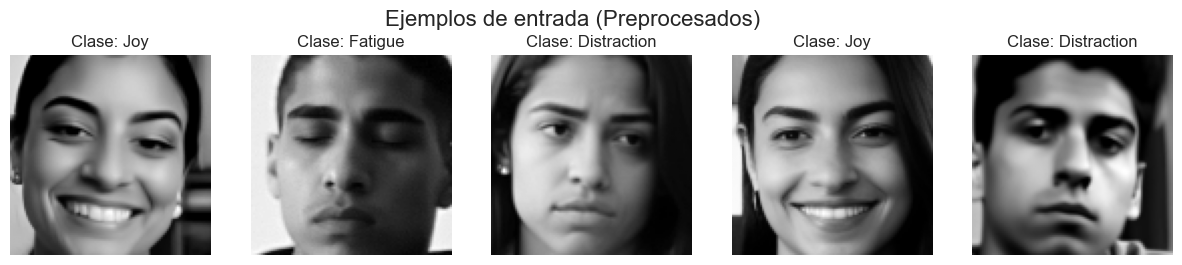

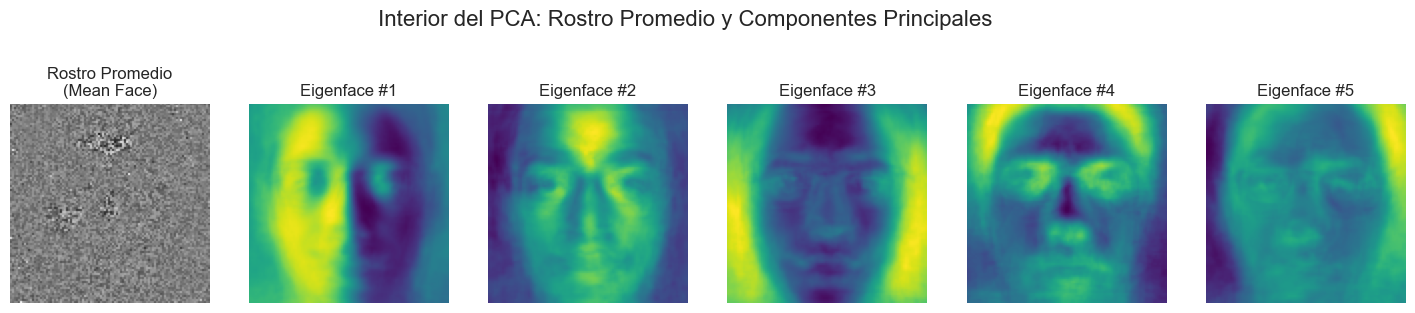

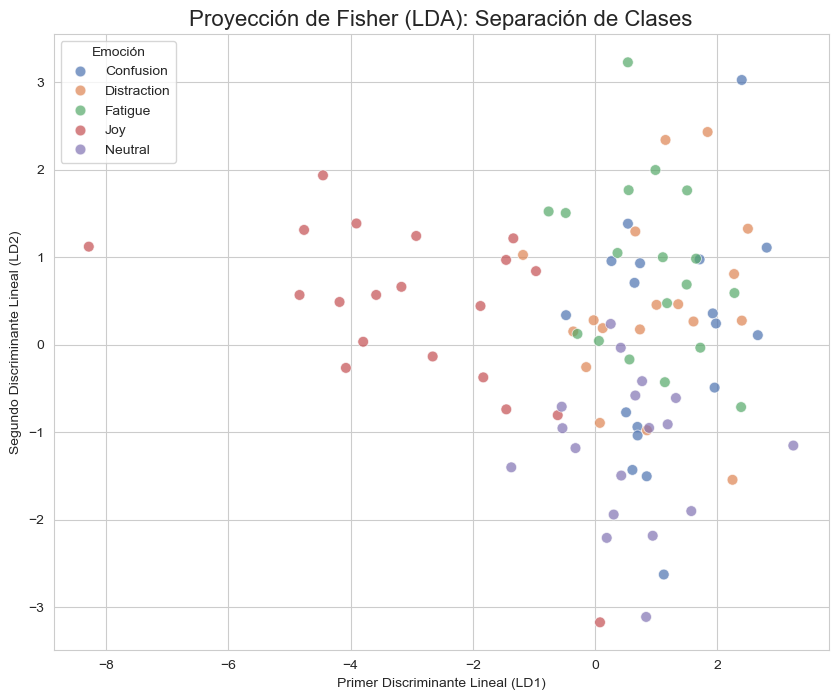

In [47]:
print("Generando gráficas del proceso...")

# 1. Ver ejemplos de datos
plot_samples(X_full_train, y_full_train)

# 2. Ver qué aprendió el PCA (Eigenfaces)
plot_eigenfaces(pca)

# 3. Ver cómo separa los grupos el LDA
plot_lda_space(lda, X_test_pca, y_test)

In [10]:
print(f"Número total de Eigenfaces encontradas: {pca.n_components_}")

Número total de Eigenfaces encontradas: 148


Generando promedios por clase...


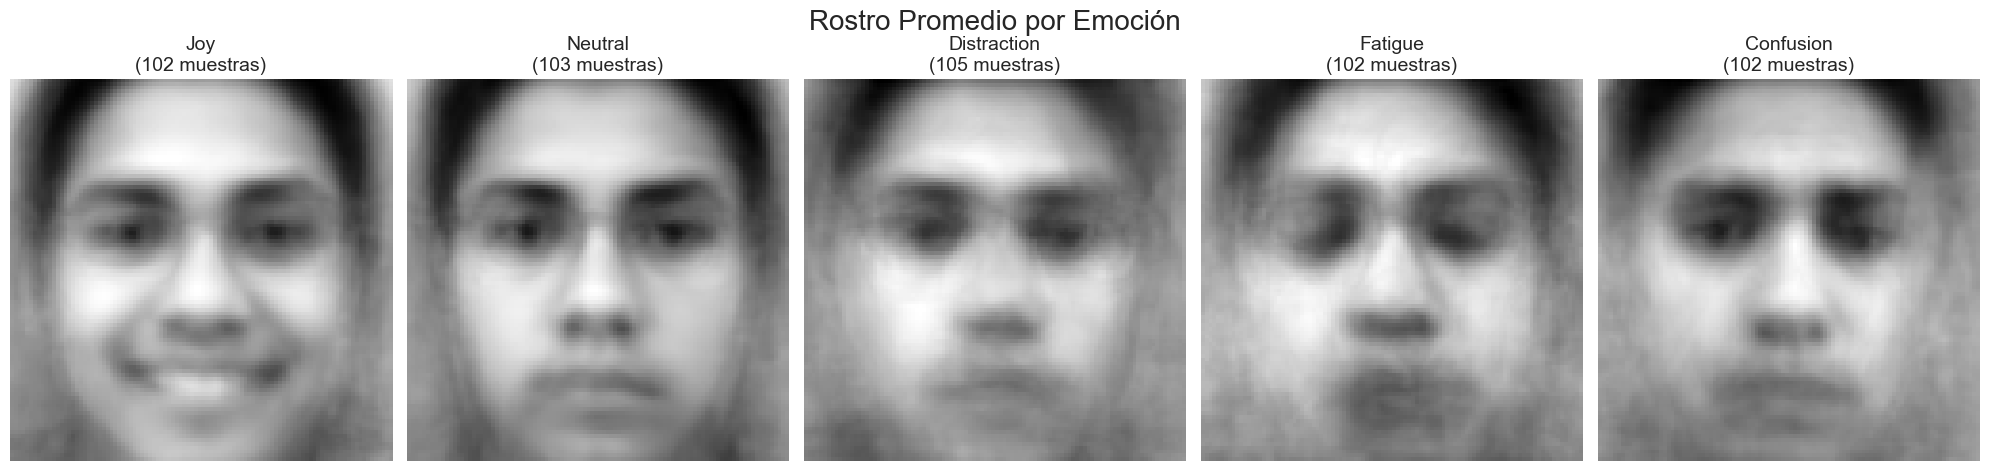

In [11]:
nombres_clases = ["Joy", "Neutral", "Distraction", "Fatigue", "Confusion"]

def visualizar_rostros_promedio(X, y):
    fig, axes = plt.subplots(1, 5, figsize=(20, 5))
    
    print("Generando promedios por clase...")
    
    for i in range(5):
        #Filtramos todas las imágenes que pertenecen a la clase 'i'
        indices_clase = np.where(y == i)[0]
        imagenes_clase = X[indices_clase]
        
        if len(imagenes_clase) > 0:
            #Calculamos el promedio a lo largo del eje 0
            imagen_promedio = np.mean(imagenes_clase, axis=0)
            
            img_visual = imagen_promedio.reshape(100, 100)
            
            axes[i].imshow(img_visual, cmap='gray')
            axes[i].set_title(f"{nombres_clases[i]}\n({len(imagenes_clase)} muestras)", fontsize=14)
            axes[i].axis('off')
        else:
            axes[i].text(0.5, 0.5, "Sin datos", ha='center')
            axes[i].axis('off')

    plt.suptitle("Rostro Promedio por Emoción", fontsize=20)
    plt.tight_layout()
    plt.show()

visualizar_rostros_promedio(X_full_train, y_full_train)

## Evaluación del test sintético

In [12]:
y_pred = lda.predict(X_test_pca)

# Métricas Globales
acc = accuracy_score(y_test, y_pred)
print(f"ACCURACY GLOBAL: {acc:.4f}")

# Reporte detallado por clase (Precision, Recall, F1)
nombres_clases = ["Joy", "Neutral", "Distraction", "Fatigue", "Confusion"]
print("\nReporte de Clasificación:")
print(classification_report(y_test, y_pred, target_names=nombres_clases))

ACCURACY GLOBAL: 0.5978

Reporte de Clasificación:
              precision    recall  f1-score   support

         Joy       1.00      0.80      0.89        20
     Neutral       0.54      0.72      0.62        18
 Distraction       0.52      0.61      0.56        18
     Fatigue       0.50      0.33      0.40        18
   Confusion       0.47      0.50      0.49        18

    accuracy                           0.60        92
   macro avg       0.61      0.59      0.59        92
weighted avg       0.62      0.60      0.60        92



### Matriz de confusión

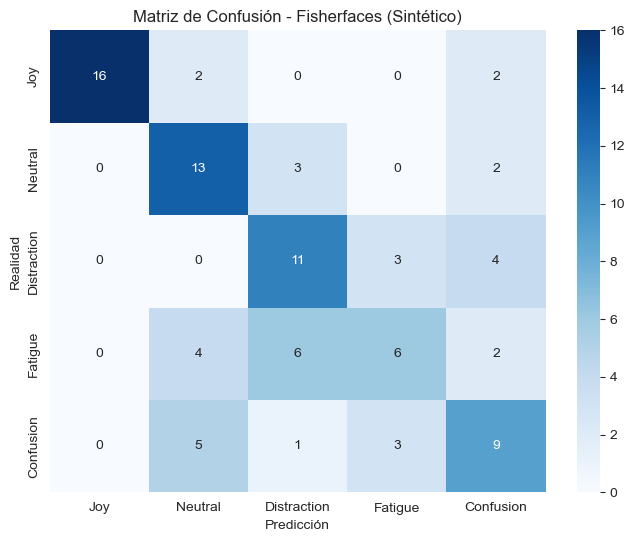

In [13]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=nombres_clases, yticklabels=nombres_clases)
plt.xlabel('Predicción')
plt.ylabel('Realidad')
plt.title('Matriz de Confusión - Fisherfaces (Sintético)')
plt.show()

## Evaluación Sintética Fisherfaces

Análisis de tus Resultados (Fisherfaces Mejorado)
1. Joy tiene una precisión: 1.00 (Perfecta)

Esto es muy positivo. Al recortar la cara, la característica de "dientes mostrándose" y "comisuras hacia arriba" se volvió matemáticamente inconfundible para el algoritmo LDA frente a las otras 4 emociones neutras.

2. Fatigue vs. Distraction

Solo acertó 6 veces.
Confundió 6 veces Fatiga con Distraction.
Confundió 4 veces Fatiga con Neutral.


El modelo presenta dificultades para distinguir la 'Fatiga'. Matemáticamente, un rostro cansado (párpados caídos) tiene una varianza de píxeles muy similar a un rostro distraído o neutral. A diferencia de 'Joy', la fatiga no introduce cambios geométricos drásticos de alto contraste, lo que dificulta la separación lineal que intenta Fisherfaces.

## Evalución capturas del equipo

### Carga de imagenes dados los clips

In [29]:
# --- CONFIGURACIÓN GLOBAL ---
RUTA_BASE = "Equipo"  # Carpeta raíz donde están todos los integrantes
FRAMES_POR_SEGUNDO = 3

# Extensiones de video a buscar
EXTENSIONES = ['*.mp4', '*.mov', '*.avi', '*.mkv']

def procesar_videos_todos_los_miembros():
    # Verificamos que exista la carpeta base
    if not os.path.exists(RUTA_BASE):
        print(f"Error: La carpeta base '{RUTA_BASE}' no existe.")
        return

    # Obtenemos la lista de carpetas (miembros del equipo) dentro de "Equipo/"
    # Filtramos para asegurarnos de que sean directorios y no archivos sueltos
    miembros = [d for d in os.listdir(RUTA_BASE) if os.path.isdir(os.path.join(RUTA_BASE, d))]
    
    total_global_imagenes = 0

    print(f"Miembros detectados: {miembros}\n")

    for miembro in miembros:
        print(f"--- Procesando miembro: {miembro} ---")
        
        # Rutas específicas para este miembro
        ruta_miembro = os.path.join(RUTA_BASE, miembro)
        
        # El ID del sujeto será el nombre de la carpeta (ej. "Bryan", "Daniel")
        # Si prefieres códigos como S01, S02, habría que hacer un diccionario o mapeo aparte.
        # Aquí usaremos el nombre del miembro para facilitar la identificación.
        sujeto_id = miembro 

        # Recorrer carpetas de emociones dentro del miembro
        carpetas_emocion = [d for d in os.listdir(ruta_miembro) if os.path.isdir(os.path.join(ruta_miembro, d))]
        
        for emocion in carpetas_emocion:
            ruta_emocion = os.path.join(ruta_miembro, emocion)
            
            # Buscar videos dentro de esta carpeta de emoción
            archivos_video = []
            for ext in EXTENSIONES:
                archivos_video.extend(glob.glob(os.path.join(ruta_emocion, ext)))
            
            if not archivos_video:
                continue # Si no hay videos en esta emoción, saltamos
                
            print(f"  > Emoción '{emocion}': {len(archivos_video)} videos encontrados.")
            
            for i, video_path in enumerate(archivos_video):
                nombre_video = os.path.basename(video_path)
                
                # Definir ID del clip (C01, C02...) basado en el orden encontrado
                clip_id = str(i+1).zfill(2)
                
                # --- Lógica de Extracción ---
                cap = cv2.VideoCapture(video_path)
                if not cap.isOpened():
                    print(f"    Error leyendo video: {nombre_video}")
                    continue
                    
                fps_video = cap.get(cv2.CAP_PROP_FPS)
                if fps_video == 0: # Evitar división por cero si el video está corrupto
                    cap.release()
                    continue

                step = int(fps_video / FRAMES_POR_SEGUNDO)
                if step < 1: step = 1
                
                frame_count = 0
                guardados_clip = 0
                
                while True:
                    ret, frame = cap.read()
                    if not ret: break
                    
                    if frame_count % step == 0:
                        # Nombre: Miembro_Clip_Frame_Emocion.png
                        # Ejemplo: Bryan_C01_f0032_joy.png
                        nombre_img = f"{sujeto_id}_C{clip_id}_f{guardados_clip}_{emocion}.png"
                        ruta_final = os.path.join(ruta_emocion, nombre_img)
                        
                        # Evitar sobrescribir si ya existe (opcional, pero buena práctica) o simplemente escribir
                        cv2.imwrite(ruta_final, frame)
                        guardados_clip += 1
                        total_global_imagenes += 1
                    
                    frame_count += 1
                
                cap.release()
                print(f"    Video {nombre_video} -> {guardados_clip} imágenes extraídas.")

    print(f"\nPROCESO TOTAL TERMINADO. Total de imágenes generadas: {total_global_imagenes}")

# Ejecutar
procesar_videos_todos_los_miembros()

Miembros detectados: ['Bryan', 'Daniel', 'Ricardo', 'Scarlet']

--- Procesando miembro: Bryan ---
  > Emoción 'confused': 1 videos encontrados.
    Video confused1.mp4 -> 13 imágenes extraídas.
  > Emoción 'distracted': 1 videos encontrados.
    Video distracted1.mp4 -> 13 imágenes extraídas.
  > Emoción 'fatigued': 1 videos encontrados.
    Video fatigued1.mp4 -> 14 imágenes extraídas.
  > Emoción 'joyful': 1 videos encontrados.
    Video joyful1.mp4 -> 14 imágenes extraídas.
  > Emoción 'neutral': 1 videos encontrados.
    Video neutral1.mp4 -> 14 imágenes extraídas.
--- Procesando miembro: Daniel ---
  > Emoción 'confused': 1 videos encontrados.
    Video confused.mp4 -> 16 imágenes extraídas.
  > Emoción 'distracted': 1 videos encontrados.
    Video distracted.mp4 -> 16 imágenes extraídas.
  > Emoción 'fatigued': 1 videos encontrados.
    Video fatigued.mp4 -> 22 imágenes extraídas.
  > Emoción 'joyful': 1 videos encontrados.
    Video joyful.mp4 -> 16 imágenes extraídas.
  > Emoci

### Despliegue de muestras

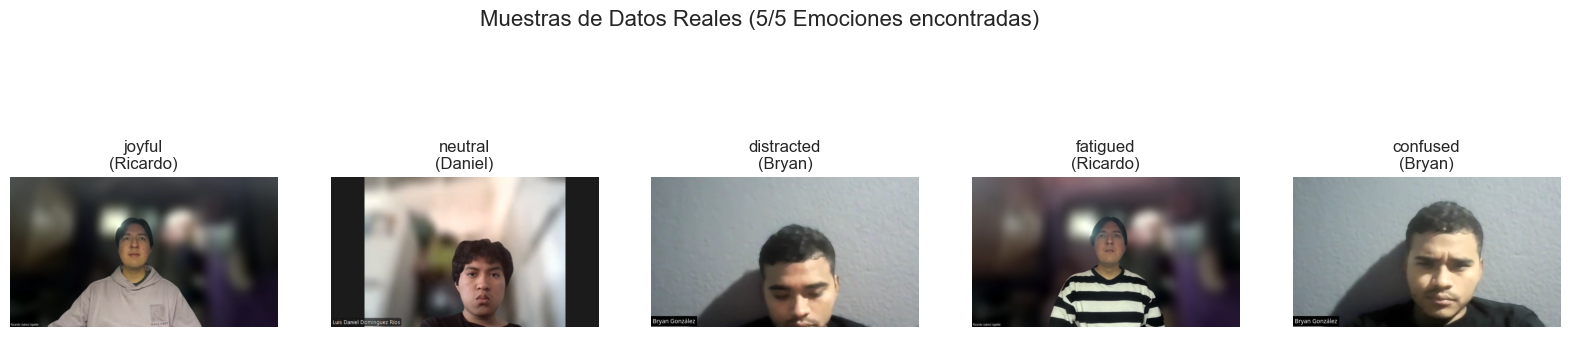

In [30]:
RUTA_BASE = "Equipo" 
CLASES = ["joyful", "neutral", "distracted", "fatigued", "confused"]

def mostrar_ejemplos_reales():
    plt.figure(figsize=(20, 5))
    encontrados = 0
    
    # Obtenemos la lista de carpetas disponibles (los integrantes del equipo)
    if os.path.exists(RUTA_BASE):
        posibles_participantes = [d for d in os.listdir(RUTA_BASE) if os.path.isdir(os.path.join(RUTA_BASE, d))]
    else:
        print(f"La ruta {RUTA_BASE} no existe.")
        return

    for i, emocion in enumerate(CLASES):
        imagen_encontrada = False
        
        # Mezclamos los participantes para que el orden de búsqueda sea aleatorio en cada emoción
        random.shuffle(posibles_participantes)
        
        for participante in posibles_participantes:
            ruta_carpeta = os.path.join(RUTA_BASE, participante, emocion)
            
            # Verificamos si existe la carpeta y si tiene imágenes
            if os.path.exists(ruta_carpeta):
                imagenes = [f for f in os.listdir(ruta_carpeta) if f.endswith(('.png', '.jpg'))]
                
                if len(imagenes) > 0:
                    # Seleccionar una imagen al azar de este participante
                    img_nombre = random.choice(imagenes)
                    img_path = os.path.join(ruta_carpeta, img_nombre)
                    
                    img = mpimg.imread(img_path)
                    
                    ax = plt.subplot(1, 5, i + 1)
                    plt.imshow(img)
                    # Mostramos la emoción y el nombre de la carpeta (participante) seleccionada
                    plt.title(f"{emocion}\n({participante})") 
                    plt.axis("off")
                    encontrados += 1
                    imagen_encontrada = True
                    break # Se encontró imagen para esta emoción, dejamos de buscar en otros participantes

        # Si después de revisar a todos los participantes no hay imagen:
        if not imagen_encontrada:
            ax = plt.subplot(1, 5, i + 1)
            plt.text(0.5, 0.5, "No encontrada\nen ningún equipo", ha='center')
            plt.title(emocion)
            plt.axis("off")

    plt.suptitle(f"Muestras de Datos Reales ({encontrados}/5 Emociones encontradas)", fontsize=16)
    plt.show()

mostrar_ejemplos_reales()

### Prueba del modelo

In [34]:
# --- 1. CARGAR DATOS REALES DE TODOS LOS MIEMBROS ---
RUTA_BASE = "Equipo" 

print(f"--- Cargando datos reales masivos desde: {RUTA_BASE} ---")

X_lista_temp = []
y_lista_temp = []

# Detectamos todas las carpetas (Daniel, Bryan, etc.)
if os.path.exists(RUTA_BASE):
    miembros = [d for d in os.listdir(RUTA_BASE) if os.path.isdir(os.path.join(RUTA_BASE, d))]
    
    for miembro in miembros:
        ruta_miembro = os.path.join(RUTA_BASE, miembro)
        print(f"  > Procesando sujeto: {miembro}...")
        
        # Llamamos a la función de carga para este miembro específico
        # Nota: Asumimos que 'cargar_datos_fisher_mejorado' devuelve numpy arrays
        X_part, y_part = cargar_datos_fisher_mejorado(ruta_miembro)
        
        if len(X_part) > 0:
            X_lista_temp.append(X_part)
            y_lista_temp.append(y_part)
            print(f"    - {len(X_part)} imágenes cargadas.")
        else:
            print(f"    - Sin imágenes válidas.")
else:
    print(f"ERROR: La ruta base {RUTA_BASE} no existe.")

# Concatenamos todos los datos en un solo dataset
if len(X_lista_temp) > 0:
    X_real = np.vstack(X_lista_temp)      # Une todas las matrices de características
    y_real = np.concatenate(y_lista_temp) # Une todas las etiquetas
else:
    X_real, y_real = [], []

--- Cargando datos reales masivos desde: Equipo ---
  > Procesando sujeto: Bryan...
Procesando: Equipo\Bryan
    - 68 imágenes cargadas.
  > Procesando sujeto: Daniel...
Procesando: Equipo\Daniel
    - 83 imágenes cargadas.
  > Procesando sujeto: Ricardo...
Procesando: Equipo\Ricardo
    - 100 imágenes cargadas.
  > Procesando sujeto: Scarlet...
Procesando: Equipo\Scarlet
    - Sin imágenes válidas.



--- TOTAL CARGADO: 251 imágenes reales combinadas ---
Aplicando transformaciones (Scaler -> PCA)...
Evaluando modelo Fisherfaces en datos reales combinados...

ACCURACY GLOBAL EN DATOS REALES: 0.4223

Reporte de Clasificación (Todos los sujetos):
              precision    recall  f1-score   support

         Joy       0.88      0.60      0.71        50
     Neutral       0.10      0.02      0.03        51
 Distraction       0.27      0.64      0.38        50
     Fatigue       0.52      0.50      0.51        54
   Confusion       0.43      0.35      0.39        46

    accuracy                           0.42       251
   macro avg       0.44      0.42      0.40       251
weighted avg       0.44      0.42      0.41       251



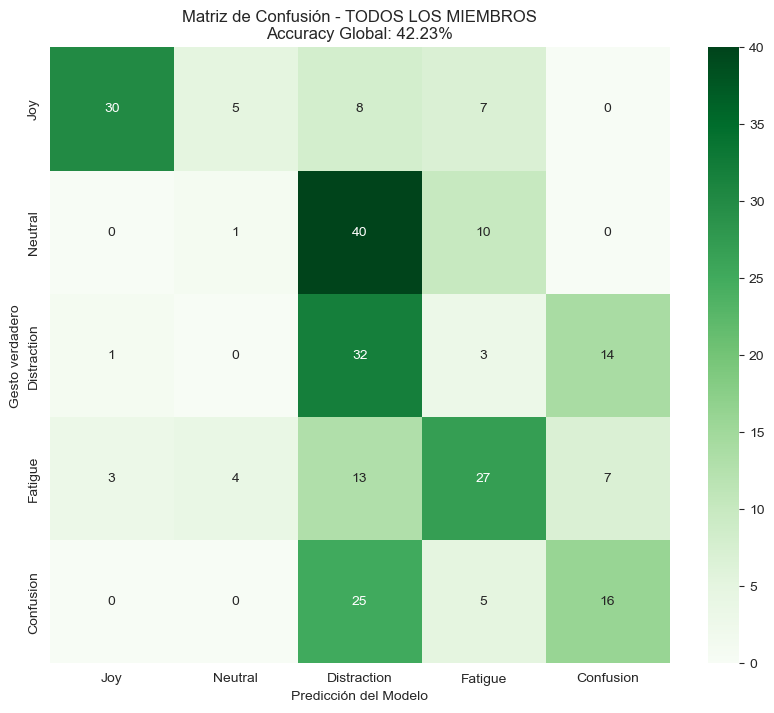

In [35]:
# --- VALIDACIÓN Y EJECUCIÓN ---
if len(X_real) == 0:
    print("\nERROR CRÍTICO: No se cargaron imágenes de ningún miembro.")
else:
    print(f"\n--- TOTAL CARGADO: {len(X_real)} imágenes reales combinadas ---")

    # --- 2. PREPROCESAMIENTO (CRÍTICO) ---
    print("Aplicando transformaciones (Scaler -> PCA)...")
    
    # a) Estandarizar con la media/varianza del dataset de ENTRENAMIENTO (sintético)
    X_real_scaled = scaler.transform(X_real)
    
    # b) Proyectar al espacio de Eigenfaces (PCA)
    X_real_pca = pca.transform(X_real_scaled)

    # --- 3. PREDICCIÓN Y EVALUACIÓN ---
    print("Evaluando modelo Fisherfaces en datos reales combinados...")
    y_pred_real = lda.predict(X_real_pca)

    # --- 4. RESULTADOS ---
    acc_real = accuracy_score(y_real, y_pred_real)
    print(f"\nACCURACY GLOBAL EN DATOS REALES: {acc_real:.4f}")
    
    nombres_clases = ["Joy", "Neutral", "Distraction", "Fatigue", "Confusion"]
    
    print("\nReporte de Clasificación (Todos los sujetos):")
    # zero_division=0 evita warnings si alguna clase no se predice nunca
    print(classification_report(y_real, y_pred_real, target_names=nombres_clases, zero_division=0))

    # Matriz de Confusión
    cm_real = confusion_matrix(y_real, y_pred_real)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm_real, annot=True, fmt='d', cmap='Greens', 
                xticklabels=nombres_clases, yticklabels=nombres_clases)
    
    plt.xlabel('Predicción del Modelo')
    plt.ylabel('Gesto verdadero')
    plt.title(f'Matriz de Confusión - TODOS LOS MIEMBROS\nAccuracy Global: {acc_real:.2%}')
    plt.show()

### Nivel Clip

In [60]:
def cargar_datos_fisher_con_nombres(ruta_split):
    X = []
    y = []
    filenames = [] # Nueva lista para guardar nombres
    
    # Aseguramos el orden de clases igual que en el entrenamiento
    clases_validas = ["joyful", "neutral", "distracted", "fatigued", "confused"]
    mapa_etiquetas = {nombre: i for i, nombre in enumerate(clases_validas)}
    
    if not os.path.exists(ruta_split):
        return np.array([]), np.array([]), np.array([])

    carpetas_emocion = os.listdir(ruta_split)
    
    for nombre_carpeta in carpetas_emocion:
        nombre_lower = nombre_carpeta.lower()
        
        # Mapeo manual simple por si las carpetas tienen mayúsculas
        if nombre_lower == "joy": nombre_lower = "joyful"
        if nombre_lower == "fatigue": nombre_lower = "fatigued"
        if nombre_lower == "confusion": nombre_lower = "confused"
        if nombre_lower == "distraction": nombre_lower = "distracted"

        if nombre_lower in mapa_etiquetas:
            label = mapa_etiquetas[nombre_lower]
            ruta_emocion = os.path.join(ruta_split, nombre_carpeta)
            
            for archivo in os.listdir(ruta_emocion):
                ruta_img = os.path.join(ruta_emocion, archivo)
                try:
                    # Leer en escala de grises
                    img = cv2.imread(ruta_img, cv2.IMREAD_GRAYSCALE)
                    if img is not None:
                        # 1. Detectar y Recortar (Usamos tu funcion existente)
                        img_face = detectar_y_recortar(img)
                        
                        # 2. Resize forzoso a 100x100
                        img_resized = cv2.resize(img_face, (100, 100))
                        
                        # 3. Guardar datos
                        X.append(img_resized.flatten())
                        y.append(label)
                        filenames.append(archivo) # Guardamos el nombre "Daniel_C01..."
                except Exception:
                    pass 

    return np.array(X), np.array(y), np.array(filenames)

--- Cargando datos reales masivos desde: Equipo ---
  > Bryan: 68 imágenes.
  > Daniel: 83 imágenes.
  > Ricardo: 100 imágenes.

Proyectando datos en espacio PCA y clasificando...
Agrupando por video...
Total de clips (videos) encontrados: 15

=== RESULTADOS FISHERFACES NIVEL CLIP ===
ACCURACY GLOBAL: 0.4667

Reporte de Clasificación:
              precision    recall  f1-score   support

      joyful       1.00      0.67      0.80         3
     neutral       0.00      0.00      0.00         3
  distracted       0.22      0.67      0.33         3
    fatigued       1.00      0.67      0.80         3
    confused       0.50      0.33      0.40         3

    accuracy                           0.47        15
   macro avg       0.54      0.47      0.47        15
weighted avg       0.54      0.47      0.47        15



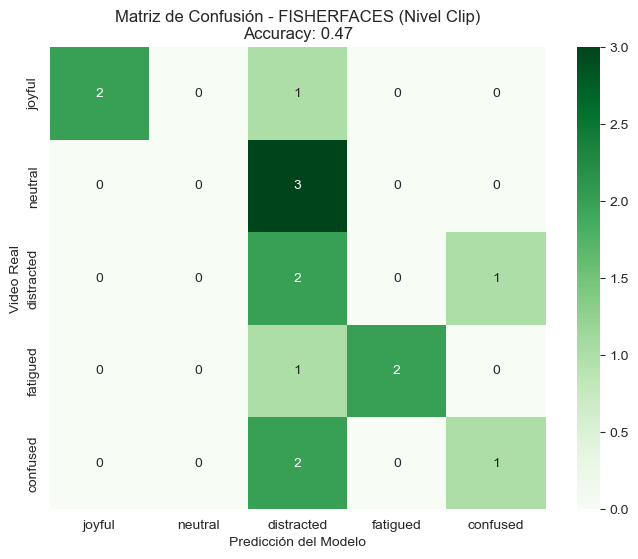

In [61]:
# --- 1. CARGA DE DATOS CON NOMBRES ---
RUTA_BASE = "Equipo" 
print(f"--- Cargando datos reales masivos desde: {RUTA_BASE} ---")

X_lista = []
y_lista = []
f_lista = [] # Lista para nombres

if os.path.exists(RUTA_BASE):
    miembros = [d for d in os.listdir(RUTA_BASE) if os.path.isdir(os.path.join(RUTA_BASE, d))]
    for miembro in miembros:
        ruta_miembro = os.path.join(RUTA_BASE, miembro)
        # Usamos la nueva función
        X_p, y_p, f_p = cargar_datos_fisher_con_nombres(ruta_miembro)
        
        if len(X_p) > 0:
            X_lista.append(X_p)
            y_lista.append(y_p)
            f_lista.append(f_p)
            print(f"  > {miembro}: {len(X_p)} imágenes.")

if len(X_lista) > 0:
    X_real = np.vstack(X_lista)
    y_real = np.concatenate(y_lista)
    filenames_real = np.concatenate(f_lista) # Array gigante de nombres
    
    # --- 2. PREPROCESAMIENTO Y PREDICCIÓN (FRAME POR FRAME) ---
    print("\nProyectando datos en espacio PCA y clasificando...")
    
    # Estandarizar y PCA (Usando los objetos ya entrenados: scaler y pca)
    X_real_scaled = scaler.transform(X_real)
    X_real_pca = pca.transform(X_real_scaled)
    
    # Predicciones individuales
    y_pred_frames = lda.predict(X_real_pca)
    
    # --- 3. AGRUPACIÓN POR CLIP (LOGICA DE VOTACIÓN) ---
    print("Agrupando por video...")
    
    clips_votes = {}
    clips_truth = {}
    
    for i, filename in enumerate(filenames_real):
        # Parseo: Sujeto_ClipID_Frame_Emocion.png
        parts = filename.split('_')
        
        # ID Único: Sujeto + ClipID + Emocion
        # Evita mezclar el C01 de Joy con el C01 de Neutral
        if len(parts) >= 4:
            unique_id = f"{parts[0]}_{parts[1]}_{parts[3].split('.')[0]}"
        else:
            unique_id = os.path.splitext(filename)[0]
            
        if unique_id not in clips_votes:
            clips_votes[unique_id] = []
            clips_truth[unique_id] = y_real[i]
            
        clips_votes[unique_id].append(y_pred_frames[i])
        
    # --- 4. CALCULAR MODA (RESULTADO FINAL POR VIDEO) ---
    y_true_clips = []
    y_pred_clips = []
    
    print(f"Total de clips (videos) encontrados: {len(clips_votes)}")
    
    for clip_id, votes in clips_votes.items():
        voto_final = mode(votes, keepdims=True)[0][0]
        y_pred_clips.append(voto_final)
        y_true_clips.append(clips_truth[clip_id])

    # --- 5. REPORTES ---
    nombres_clases = ["joyful", "neutral", "distracted", "fatigued", "confused"]
    indices_clases = [0, 1, 2, 3, 4] # Indices numéricos
    
    acc = accuracy_score(y_true_clips, y_pred_clips)
    print(f"\n=== RESULTADOS FISHERFACES NIVEL CLIP ===")
    print(f"ACCURACY GLOBAL: {acc:.4f}")
    
    print("\nReporte de Clasificación:")
    print(classification_report(y_true_clips, y_pred_clips, 
                                target_names=nombres_clases,
                                labels=indices_clases,
                                zero_division=0))
    
    # Matriz
    cm = confusion_matrix(y_true_clips, y_pred_clips, labels=indices_clases)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Greens',
                xticklabels=nombres_clases, yticklabels=nombres_clases)
    plt.title(f'Matriz de Confusión - FISHERFACES (Nivel Clip)\nAccuracy: {acc:.2f}')
    plt.ylabel('Video Real')
    plt.xlabel('Predicción del Modelo')
    plt.show()

else:
    print("No se encontraron datos para evaluar.")

# MobileNet

## Librerias adicionales

In [38]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.callbacks import EarlyStopping
import pandas as pd


## Recortar las imágenes

In [58]:
# Rutas Base
INPUT_ROOT = "Equipo"       
OUTPUT_ROOT = "Equipo_CROP" 

# Configuración
IMG_SIZE = (224, 224)
cascade_path = 'haarcascade_frontalface_default.xml'
face_cascade = cv2.CascadeClassifier(cascade_path)

def recortar_dataset_real_masivo():
    if face_cascade.empty():
        print("Error: No se encuentra el XML del detector.")
        return

    if not os.path.exists(INPUT_ROOT):
        print(f"Error: No encuentro la carpeta {INPUT_ROOT}")
        return

    print(f"Iniciando recorte de rostros masivo en: {INPUT_ROOT}")

    miembros = [d for d in os.listdir(INPUT_ROOT) if os.path.isdir(os.path.join(INPUT_ROOT, d))]
    
    total_global = 0

    for miembro in miembros:
        print(f"--- Procesando miembro: {miembro} ---")
        
        ruta_miembro_origen = os.path.join(INPUT_ROOT, miembro)
        ruta_miembro_destino = os.path.join(OUTPUT_ROOT, miembro)
        
        if not os.path.exists(ruta_miembro_origen):
            continue

        emociones = os.listdir(ruta_miembro_origen)
        
        for emocion in emociones:
            ruta_emocion_origen = os.path.join(ruta_miembro_origen, emocion)
            ruta_emocion_destino = os.path.join(ruta_miembro_destino, emocion)
            
            if not os.path.isdir(ruta_emocion_origen): continue
            
            os.makedirs(ruta_emocion_destino, exist_ok=True)
            
            archivos = os.listdir(ruta_emocion_origen)
            count = 0
            count_fallback = 0 # Contador para imágenes guardadas sin recorte
            
            for archivo in archivos:
                if not archivo.lower().endswith(('.png', '.jpg', '.jpeg')):
                    continue

                ruta_img = os.path.join(ruta_emocion_origen, archivo)
                
                img = cv2.imread(ruta_img)
                if img is None: 
                    print(f"No se pudo leer: {ruta_img}")
                    continue
                
                # Detectar rostro
                gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                
                # MODIFICACION 1: minNeighbors=3 (mas sensible para detectar caras dificiles)
                rostros = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=3, minSize=(30, 30))
                
                if len(rostros) > 0:
                    # CASO IDEAL: Se encontró cara, se recorta
                    x, y, w, h = max(rostros, key=lambda b: b[2] * b[3])
                    face = img[y:y+h, x:x+w]
                    face_resized = cv2.resize(face, IMG_SIZE)
                    cv2.imwrite(os.path.join(ruta_emocion_destino, archivo), face_resized)
                    count += 1
                    total_global += 1
                else:
                    # MODIFICACION 2 (Plan B): Si falla la detección (común en 'distracted')
                    # Guardamos la imagen completa redimensionada para no perder el dato
                    img_resized = cv2.resize(img, IMG_SIZE)
                    cv2.imwrite(os.path.join(ruta_emocion_destino, archivo), img_resized)
                    count_fallback += 1
                    total_global += 1
            
            if count > 0 or count_fallback > 0:
                print(f"  Carpeta {emocion}: {count} recortes + {count_fallback} originales (fallback).")

    print(f"\nProceso terminado. Total imagenes listas: {total_global}")
    print(f"Ubicacion de salida: {OUTPUT_ROOT}")

# Ejecutar
recortar_dataset_real_masivo()

Iniciando recorte de rostros masivo en: Equipo
--- Procesando miembro: Bryan ---
  Carpeta confused: 13 recortes + 0 originales (fallback).
  Carpeta distracted: 0 recortes + 13 originales (fallback).
  Carpeta fatigued: 14 recortes + 0 originales (fallback).
  Carpeta joyful: 14 recortes + 0 originales (fallback).
  Carpeta neutral: 14 recortes + 0 originales (fallback).
--- Procesando miembro: Daniel ---
  Carpeta confused: 16 recortes + 0 originales (fallback).
  Carpeta distracted: 16 recortes + 0 originales (fallback).
  Carpeta fatigued: 22 recortes + 0 originales (fallback).
  Carpeta joyful: 16 recortes + 0 originales (fallback).
  Carpeta neutral: 13 recortes + 0 originales (fallback).
--- Procesando miembro: Ricardo ---
  Carpeta confused: 17 recortes + 0 originales (fallback).
  Carpeta distracted: 21 recortes + 0 originales (fallback).
  Carpeta fatigued: 15 recortes + 3 originales (fallback).
  Carpeta joyful: 20 recortes + 0 originales (fallback).
  Carpeta neutral: 24 re

## Preparación de datos

In [39]:
# 1. Rutas
DIR_SINTETICO = "Synthetic_MobileNet_Ready"
DIR_REAL_CROP = "Equipo_CROP" # Ahora apuntamos a la raíz donde están todos los sujetos

# 2. Parámetros Globales
BATCH_SIZE = 32
IMG_SHAPE = (224, 224)

# 3. Configurar Generadores
print("--- Configurando Generadores de Keras ---")
datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

# Generador de Entrenamiento
train_generator = datagen.flow_from_directory(
    os.path.join(DIR_SINTETICO, 'train'),
    target_size=IMG_SHAPE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

# Generador de Validación
val_generator = datagen.flow_from_directory(
    os.path.join(DIR_SINTETICO, 'val'),
    target_size=IMG_SHAPE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

# Generador de Prueba (Sintético)
test_generator = datagen.flow_from_directory(
    os.path.join(DIR_SINTETICO, 'test'),
    target_size=IMG_SHAPE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

# --- CONFIGURACIÓN ESPECIAL PARA DATOS REALES (Múltiples carpetas de sujetos) ---
if os.path.exists(DIR_REAL_CROP):
    print(f"Escaneando datos reales en: {DIR_REAL_CROP}")
    
    # Recorremos la estructura: Equipo_CROP -> Sujeto -> Emoción -> Imagen
    datos_reales = []
    
    # Obtenemos lista de sujetos (Daniel, Bryan, etc.)
    sujetos = [d for d in os.listdir(DIR_REAL_CROP) if os.path.isdir(os.path.join(DIR_REAL_CROP, d))]
    
    for sujeto in sujetos:
        ruta_sujeto = os.path.join(DIR_REAL_CROP, sujeto)
        emociones = os.listdir(ruta_sujeto)
        
        for emocion in emociones:
            ruta_emocion = os.path.join(ruta_sujeto, emocion)
            if os.path.isdir(ruta_emocion):
                for archivo in os.listdir(ruta_emocion):
                    if archivo.lower().endswith(('.png', '.jpg', '.jpeg')):
                        # Guardamos la ruta completa y la etiqueta (nombre de la carpeta emoción)
                        full_path = os.path.join(ruta_emocion, archivo)
                        datos_reales.append({
                            "filepath": full_path,
                            "label": emocion 
                        })

    # Creamos un DataFrame temporal
    df_real = pd.DataFrame(datos_reales)

    if not df_real.empty:
        # Usamos flow_from_dataframe para manejar la estructura compleja
        # IMPORTANTE: Forzamos el mismo orden de clases que el generador de entrenamiento
        # para que 'joy' sea el mismo número en ambos.
        classes_ordenadas = list(train_generator.class_indices.keys())
        
        real_generator = datagen.flow_from_dataframe(
            dataframe=df_real,
            x_col="filepath",
            y_col="label",
            target_size=IMG_SHAPE,
            batch_size=BATCH_SIZE,
            class_mode='categorical',
            shuffle=False,
            classes=classes_ordenadas # Sincroniza los índices con el entrenamiento
        )
        
        print(f"Indices Sintetico: {train_generator.class_indices}")
        print(f"Indices Real:      {real_generator.class_indices}")
    else:
        print("Advertencia: No se encontraron imagenes validas en las carpetas reales.")
        real_generator = None

else:
    print(f"Advertencia: No se encontro la carpeta raiz: {DIR_REAL_CROP}")

--- Configurando Generadores de Keras ---
Found 424 images belonging to 5 classes.
Found 90 images belonging to 5 classes.
Found 92 images belonging to 5 classes.
Escaneando datos reales en: Equipo_CROP
Found 235 validated image filenames belonging to 5 classes.
Indices Sintetico: {'confused': 0, 'distracted': 1, 'fatigued': 2, 'joyful': 3, 'neutral': 4}
Indices Real:      {'confused': 0, 'distracted': 1, 'fatigued': 2, 'joyful': 3, 'neutral': 4}


## Modelo

In [40]:
print("--- Construyendo Arquitectura MobileNetV2 ---")

# 1. Cargar Base Pre-entrenada 
# include_top=False elimina la capa de clasificación original de 1000 clases
base_model = MobileNetV2(input_shape=(224, 224, 3), 
                         include_top=False, 
                         weights='imagenet')

# 2. Congelar la base (Freeze
# Esto evita que se destruyan los patrones aprendidos en ImageNet
base_model.trainable = False

# 3. Construir la nueva cabeza del modelo
inputs = tf.keras.Input(shape=(224, 224, 3))
x = base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x) # Aplanar
x = layers.Dropout(0.3)(x)             # Regularización para evitar overfitting

# Capa de salida: 5 neuronas (una por CAS) con Softmax 
outputs = layers.Dense(5, activation='softmax')(x)

# 4. Compilar
model_final = models.Model(inputs, outputs)

model_final.compile(optimizer=optimizers.Adam(learning_rate=0.001), 
                    loss='categorical_crossentropy',                
                    metrics=['accuracy'])                                

model_final.summary()

--- Construyendo Arquitectura MobileNetV2 ---


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │         6,405 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,264,389 (8.64 MB)

 Trainable params: 6,405 (25.02 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

## Entrenamiento

In [41]:
print("--- Iniciando Entrenamiento ---")

# [cite_start]Configurar Early Stopping [cite: 88]
early_stopping = EarlyStopping(
    monitor='val_loss', 
    patience=5,               # Esperar 5 épocas si no mejora
    restore_best_weights=True # Regresar a la mejor versión encontrada
)

# Entrenar (Fit)
history = model_final.fit(
    train_generator,
    epochs=20, # Empezamos con 20 épocas [cite: 85]
    validation_data=val_generator,
    callbacks=[early_stopping]
)

print("Entrenamiento finalizado.")

--- Iniciando Entrenamiento ---
Epoch 1/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 15s 760ms/step - accuracy: 0.2146 - loss: 1.8626 - val_accuracy: 0.3444 - val_loss: 1.6231
Epoch 2/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 10s 688ms/step - accuracy: 0.3396 - loss: 1.5091 - val_accuracy: 0.3222 - val_loss: 1.4229
Epoch 3/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 9s 613ms/step - accuracy: 0.4363 - loss: 1.3550 - val_accuracy: 0.4667 - val_loss: 1.2612
Epoch 4/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 8s 602ms/step - accuracy: 0.5377 - loss: 1.2089 - val_accuracy: 0.4444 - val_loss: 1.2109
Epoch 5/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 8s 596ms/step - accuracy: 0.5189 - loss: 1.1653 - val_accuracy: 0.4778 - val_loss: 1.2017
Epoch 6/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 8s 636ms/step - accuracy: 0.5660 - loss: 1.0888 - val_accuracy: 0.5556 - val_loss: 1.0990
Epoch 7/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 9s 606ms/step - accuracy: 0.5849 - loss: 1.0194 - val_accuracy: 0.5667 - val_loss: 1.0821
Epoch 8/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 9s 666ms/step - accuracy: 0.6250

## Evaluación


--- Evaluando: TEST SINTÉTICO (92 imágenes) ---
2/3 ━━━━━━━━━━━━━━━━━━━━ 0s 505ms/stepWARNING:tensorflow:5 out of the last 13 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x0000024C889ED6C0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 961ms/step


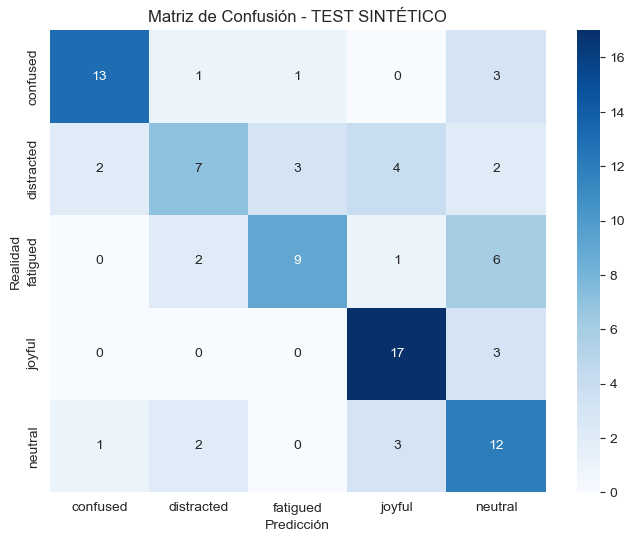

              precision    recall  f1-score   support

    confused       0.81      0.72      0.76        18
  distracted       0.58      0.39      0.47        18
    fatigued       0.69      0.50      0.58        18
      joyful       0.68      0.85      0.76        20
     neutral       0.46      0.67      0.55        18

    accuracy                           0.63        92
   macro avg       0.65      0.63      0.62        92
weighted avg       0.65      0.63      0.63        92



In [42]:
def evaluar_y_graficar(generator, nombre_set):
    # Validación de seguridad
    if generator is None or generator.n == 0:
        print(f"\n--- OMITIDO: {nombre_set} (Sin imágenes para evaluar) ---")
        return

    print(f"\n--- Evaluando: {nombre_set} ({generator.n} imágenes) ---")
    
    # 1. Obtener Predicciones
    # Es crucial resetear el generador para asegurar que empiece desde la imagen 0
    generator.reset()
    
    # verbose=1 muestra la barra de progreso
    predicciones = model_final.predict(generator, verbose=1)
    
    # Convertimos probabilidades a etiquetas numéricas (0, 1, 2...)
    y_pred = np.argmax(predicciones, axis=1)
    
    # Obtenemos las etiquetas reales del generador
    y_true = generator.classes
    
    # Obtener nombres de las clases (asegurando el orden correcto)
    # class_indices es un diccionario {'joy': 0, 'neutral': 1, ...}
    # Lo invertimos o usamos keys() ordenadas por valor
    mapa_clases = generator.class_indices
    labels = list(mapa_clases.keys()) 
    
    # 2. Matriz de Confusión
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=labels, yticklabels=labels)
    plt.title(f'Matriz de Confusión - {nombre_set}')
    plt.ylabel('Realidad')
    plt.xlabel('Predicción')
    plt.show()
    
    # 3. Reporte de Métricas
    print(classification_report(y_true, y_pred, target_names=labels, zero_division=0))

# --- Ejecutar evaluaciones ---

# 1. Evaluar Test Sintético
if 'test_generator' in locals() and test_generator is not None:
    evaluar_y_graficar(test_generator, "TEST SINTÉTICO")




--- Evaluando: DATOS REALES (Equipo Completo) (235 imágenes) ---
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 613ms/step


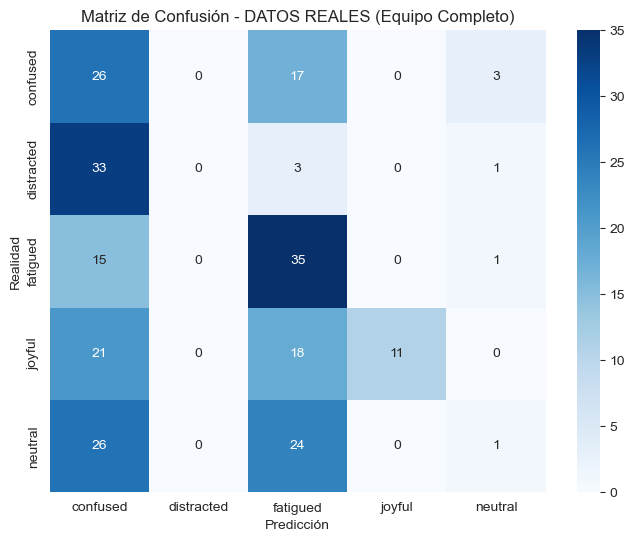

              precision    recall  f1-score   support

    confused       0.21      0.57      0.31        46
  distracted       0.00      0.00      0.00        37
    fatigued       0.36      0.69      0.47        51
      joyful       1.00      0.22      0.36        50
     neutral       0.17      0.02      0.04        51

    accuracy                           0.31       235
   macro avg       0.35      0.30      0.24       235
weighted avg       0.37      0.31      0.25       235



In [43]:
# 2. Evaluar Datos Reales (Todos los miembros procesados)
if 'real_generator' in locals() and real_generator is not None:
    evaluar_y_graficar(real_generator, "DATOS REALES (Equipo Completo)")
else:
    print("No se encontró el generador de datos reales. Revisa el paso anterior.")

### FINE-TUNING

In [23]:
print("\n--- Iniciando Fine-Tuning (Descongelando capas superiores) ---")

# 1. Descongelar el modelo base
base_model.trainable = True

# 2. Refinar qué tantas capas queremos entrenar.
# MobileNetV2 tiene muchas capas. "Ligero" significa entrenar solo las últimas.
print(f"Número total de capas en la base: {len(base_model.layers)}")

# Congelamos todas las capas EXCEPTO las últimas 30 (puedes ajustar este número)
fine_tune_at = len(base_model.layers) - 10

for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

# 3. Re-compilar (CRÍTICO: Necesario para que los cambios surtan efecto)
# REQUERIMIENTO: "Optimizer: Probar varios".
# Para Fine-Tuning, se recomienda RMSprop o SGD con un learning rate MUY bajo.

# Opción A: RMSprop (Muy bueno para MobileNet)
optimizer_ft = optimizers.RMSprop(learning_rate=1e-6)

# Opción B: SGD con momentum (Clásico para estabilidad)
# optimizer_ft = optimizers.SGD(learning_rate=1e-5, momentum=0.9)

# Opción C: Adam (pero muy lento)
# optimizer_ft = optimizers.Adam(learning_rate=1e-5)

model_final.compile(loss='categorical_crossentropy',
                    optimizer=optimizer_ft,
                    metrics=['accuracy'])

model_final.summary()

# 4. Entrenar de nuevo (Fine-Tuning)
# Las épocas se suman a las anteriores. Si hiciste 20 antes, esto empieza en la 21.
total_epochs = 20 + 20 # 20 iniciales + 20 de fine tuning

history_fine = model_final.fit(
    train_generator,
    epochs=total_epochs,
    initial_epoch=history.epoch[-1], # Continuar donde se quedó
    validation_data=val_generator,
    callbacks=[early_stopping]
)

print("Fine-Tuning finalizado.")


--- Iniciando Fine-Tuning (Descongelando capas superiores) ---
Número total de capas en la base: 154


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 5)              │         6,405 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,264,389 (8.64 MB)

 Trainable params: 738,885 (2.82 MB)

 Non-trainable params: 1,525,504 (5.82 MB)

Epoch 20/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 17s 831ms/step - accuracy: 0.5519 - loss: 1.1729 - val_accuracy: 0.6889 - val_loss: 0.9202
Epoch 21/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 9s 647ms/step - accuracy: 0.5377 - loss: 1.2031 - val_accuracy: 0.6778 - val_loss: 0.9205
Epoch 22/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 10s 687ms/step - accuracy: 0.5354 - loss: 1.2269 - val_accuracy: 0.6778 - val_loss: 0.9212
Epoch 23/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 10s 709ms/step - accuracy: 0.5920 - loss: 1.1635 - val_accuracy: 0.6667 - val_loss: 0.9223
Epoch 24/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 10s 736ms/step - accuracy: 0.5708 - loss: 1.1719 - val_accuracy: 0.6667 - val_loss: 0.9234
Fine-Tuning finalizado.


### Nueva Prueba

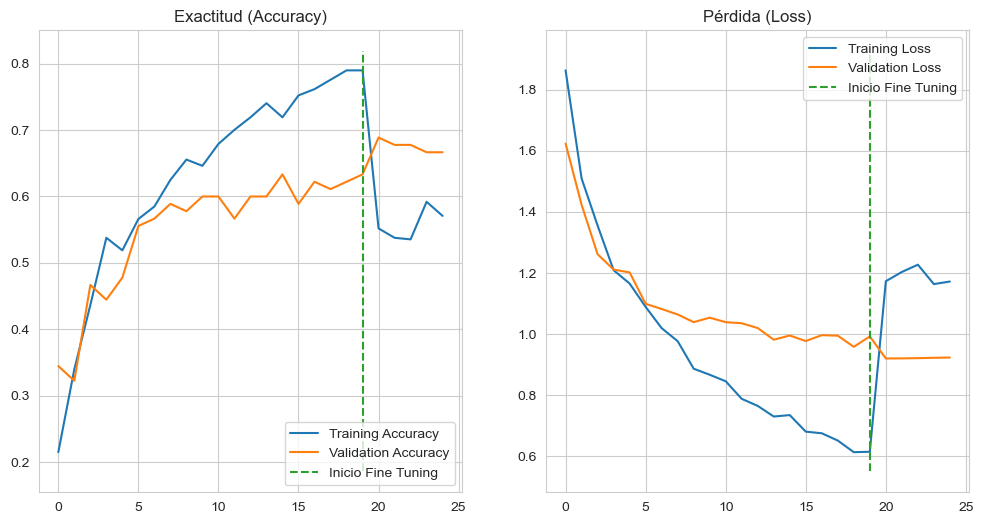

In [44]:
def graficar_evolucion(h1, h2):
    acc = h1.history['accuracy'] + h2.history['accuracy']
    val_acc = h1.history['val_accuracy'] + h2.history['val_accuracy']

    loss = h1.history['loss'] + h2.history['loss']
    val_loss = h1.history['val_loss'] + h2.history['val_loss']

    plt.figure(figsize=(12, 6))
    
    # Gráfica de Exactitud
    plt.subplot(1, 2, 1)
    plt.plot(acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.plot([len(h1.history['accuracy'])-1, len(h1.history['accuracy'])-1],
             plt.ylim(), label='Inicio Fine Tuning', linestyle='--')
    plt.legend(loc='lower right')
    plt.title('Exactitud (Accuracy)')

    # Gráfica de Pérdida
    plt.subplot(1, 2, 2)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.plot([len(h1.history['loss'])-1, len(h1.history['loss'])-1],
             plt.ylim(), label='Inicio Fine Tuning', linestyle='--')
    plt.legend(loc='upper right')
    plt.title('Pérdida (Loss)')
    
    plt.show()

graficar_evolucion(history, history_fine)



Generando matriz para: Test Sintetico...
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 510ms/step
Grafica guardada como: Confusion_Matrix_Test_Sintetico.png


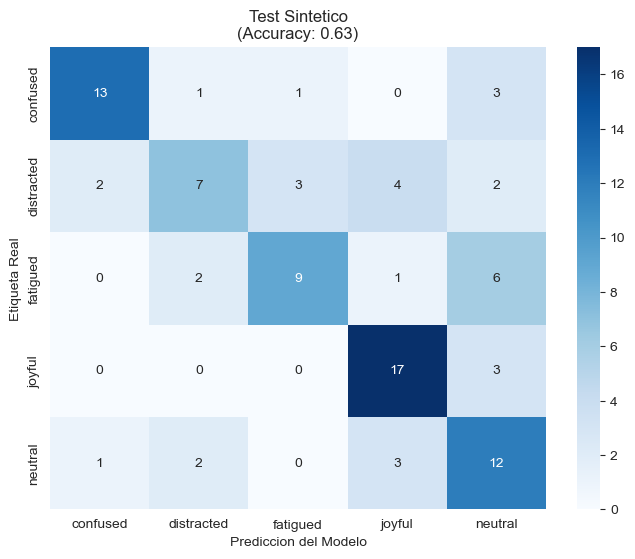


--- Reporte de Clasificacion: Test Sintetico ---
              precision    recall  f1-score   support

    confused       0.81      0.72      0.76        18
  distracted       0.58      0.39      0.47        18
    fatigued       0.69      0.50      0.58        18
      joyful       0.68      0.85      0.76        20
     neutral       0.46      0.67      0.55        18

    accuracy                           0.63        92
   macro avg       0.65      0.63      0.62        92
weighted avg       0.65      0.63      0.63        92



In [45]:
def plot_confusion_matrix_custom(generator, model, title="Matriz de Confusión"):
    print(f"\nGenerando matriz para: {title}...")
    
    # 1. Obtener predicciones
    generator.reset() # Reiniciar el generador para asegurar el orden correcto
    predictions = model.predict(generator, verbose=1)
    y_pred = np.argmax(predictions, axis=1)
    y_true = generator.classes
    
    # 2. Obtener etiquetas reales (nombres de las clases)
    class_names = list(generator.class_indices.keys())
    
    # 3. Crear matriz
    cm = confusion_matrix(y_true, y_pred)
    
    # 4. Graficar
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names)
    
    # Calcular accuracy para mostrarlo en el título
    acc_score = accuracy_score(y_true, y_pred)
    plt.title(f'{title}\n(Accuracy: {acc_score:.2f})')
    plt.ylabel('Etiqueta Real')
    plt.xlabel('Prediccion del Modelo')
    
    # Guardar la imagen automáticamente
    filename = f"Confusion_Matrix_{title.replace(' ', '_')}.png"
    plt.savefig(filename)
    print(f"Grafica guardada como: {filename}")
    plt.show()
    
    # 5. Imprimir reporte de texto
    print(f"\n--- Reporte de Clasificacion: {title} ---")
    print(classification_report(y_true, y_pred, target_names=class_names, zero_division=0))

# --- EJECUTAR EVALUACIÓN ---

# 1. Evaluar en datos de prueba (Sintéticos)
if 'test_generator' in locals() and test_generator is not None:
    plot_confusion_matrix_custom(test_generator, model_final, title="Test Sintetico")



Evaluando en tus datos reales...

Generando matriz para: Datos Reales (Tu Equipo)...
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 466ms/step
Grafica guardada como: Confusion_Matrix_Datos_Reales_(Tu_Equipo).png


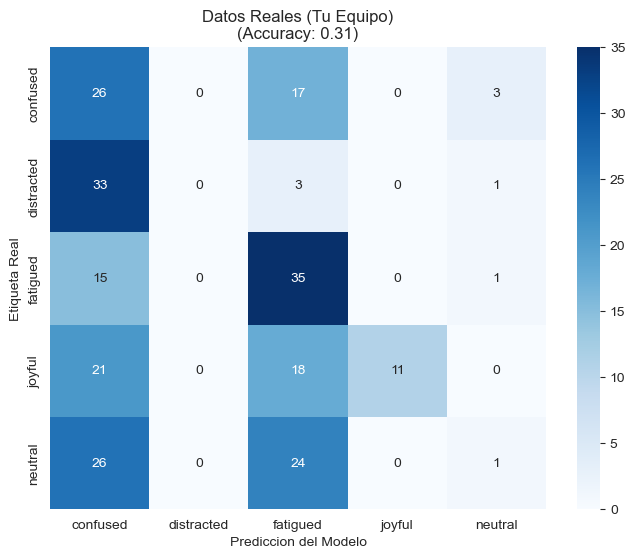


--- Reporte de Clasificacion: Datos Reales (Tu Equipo) ---
              precision    recall  f1-score   support

    confused       0.21      0.57      0.31        46
  distracted       0.00      0.00      0.00        37
    fatigued       0.36      0.69      0.47        51
      joyful       1.00      0.22      0.36        50
     neutral       0.17      0.02      0.04        51

    accuracy                           0.31       235
   macro avg       0.35      0.30      0.24       235
weighted avg       0.37      0.31      0.25       235



In [46]:
# 2. Evaluar en datos reales (Todas las carpetas del equipo procesadas)
if 'real_generator' in locals() and real_generator is not None:
    print("\nEvaluando en tus datos reales...")
    plot_confusion_matrix_custom(real_generator, model_final, title="Datos Reales (Tu Equipo)")
else:
    print("\nAdvertencia: No se encontro el generador de datos reales.")


--- INICIANDO EVALUACIÓN A NIVEL CLIP (VIDEO) ---
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 515ms/step
Agrupando frames por clip (Sujeto + ID + Emoción)...
Total de clips (videos) únicos identificados: 14

=== RESULTADOS NIVEL CLIP ===
ACCURACY GLOBAL (Por Video): 0.3571

Reporte de Clasificación (Por Video):
              precision    recall  f1-score   support

    confused       0.25      0.67      0.36         3
  distracted       0.00      0.00      0.00         2
    fatigued       0.50      1.00      0.67         3
      joyful       0.00      0.00      0.00         3
     neutral       0.00      0.00      0.00         3

    accuracy                           0.36        14
   macro avg       0.15      0.33      0.21        14
weighted avg       0.16      0.36      0.22        14



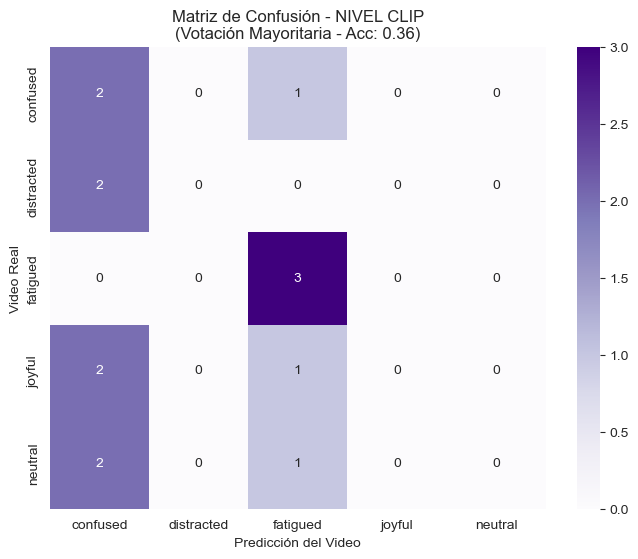

In [59]:
def evaluar_nivel_clip_corregido(generator, model):
    print("\n--- INICIANDO EVALUACIÓN A NIVEL CLIP (VIDEO) ---")
    
    # 1. Obtener predicciones frame por frame
    generator.reset()
    predicciones_raw = model.predict(generator, verbose=1)
    y_pred_frames = np.argmax(predicciones_raw, axis=1)
    
    # 2. Datos del generador
    filenames = generator.filenames
    y_true_frames = generator.classes
    class_labels = list(generator.class_indices.keys())
    all_labels_indices = range(len(class_labels))
    
    # Diccionarios para agrupar
    clips_votes = {}
    clips_truth = {}
    
    print("Agrupando frames por clip (Sujeto + ID + Emoción)...")
    
    for i, filepath in enumerate(filenames):
        # El filepath viene del generador, ej: "Daniel/joy/Daniel_C01_f032_joy.png"
        filename = os.path.basename(filepath)
        
        # Parseamos el nombre: Sujeto_ClipID_Frame_Emocion.png
        # Ejemplo: parts = ['Daniel', 'C01', 'f032', 'joy.png']
        parts = filename.split('_')
        
        if len(parts) >= 4:
            sujeto = parts[0]
            clip_num = parts[1] # C01
            # Importante: Usamos también la emoción (parte 3 sin extension) para diferenciar
            # el C01 de Joy del C01 de Neutral
            emocion_tag = parts[3].split('.')[0] 
            
            # CREAMOS UN ID ÚNICO REALMENTE ESPECÍFICO
            unique_clip_id = f"{sujeto}_{clip_num}_{emocion_tag}"
        else:
            # Fallback si el nombre no cumple el formato, usamos el nombre base
            unique_clip_id = os.path.splitext(filename)[0]
            
        if unique_clip_id not in clips_votes:
            clips_votes[unique_clip_id] = []
            clips_truth[unique_clip_id] = y_true_frames[i]
            
        clips_votes[unique_clip_id].append(y_pred_frames[i])

    # 3. Votación Mayoritaria
    y_true_clips = []
    y_pred_clips = []
    
    print(f"Total de clips (videos) únicos identificados: {len(clips_votes)}")
    
    for clip_id, votes in clips_votes.items():
        # La moda decide la etiqueta del video
        voto_final = mode(votes, keepdims=True)[0][0]
        y_pred_clips.append(voto_final)
        y_true_clips.append(clips_truth[clip_id])

    # 4. Métricas
    acc_clip = accuracy_score(y_true_clips, y_pred_clips)
    print(f"\n=== RESULTADOS NIVEL CLIP ===")
    print(f"ACCURACY GLOBAL (Por Video): {acc_clip:.4f}")
    
    print("\nReporte de Clasificación (Por Video):")
    print(classification_report(y_true_clips, y_pred_clips, 
                                target_names=class_labels, 
                                labels=all_labels_indices,
                                zero_division=0))
    
    # 5. Matriz de Confusión
    cm = confusion_matrix(y_true_clips, y_pred_clips, labels=all_labels_indices)
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Purples', 
                xticklabels=class_labels, yticklabels=class_labels)
    plt.title(f'Matriz de Confusión - NIVEL CLIP\n(Votación Mayoritaria - Acc: {acc_clip:.2f})')
    plt.ylabel('Video Real')
    plt.xlabel('Predicción del Video')
    plt.show()

# --- EJECUTAR ---
if 'real_generator' in locals() and real_generator is not None:
    evaluar_nivel_clip_corregido(real_generator, model_final)
else:
    print("Error: No hay generador real cargado.")